In [1]:
from utils import *

In [2]:
#definition of constant
N = 1000 #number of sample
np.random.seed(0) #for reproductivity

# Example of posterior distributions

In [3]:
#constant of the inverse problem
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2

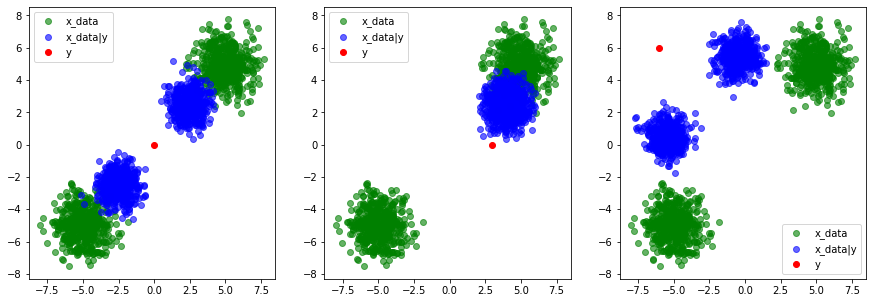

In [4]:
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)

sample_prior = sample_gaussian(mu_list, sigma_list, pi_list, N)

Y = [np.array([0,0]), np.array([3,0]), np.array([-6,6])] #observation
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    sample_post = sample_posterior(A, Y[i], sigma, N, mu_list, sigma_list, pi_list)

    ax[i].scatter(sample_prior[:, 0], sample_prior[:, 1], alpha=0.6, c='g')
    ax[i].scatter(sample_post[:,0], sample_post[:,1], alpha=0.6, c='b')
    ax[i].grid(False)
    ax[i].plot(Y[i][0],Y[i][1], 'ro')
    ax[i].legend(['x_data', 'x_data|y', 'y'])

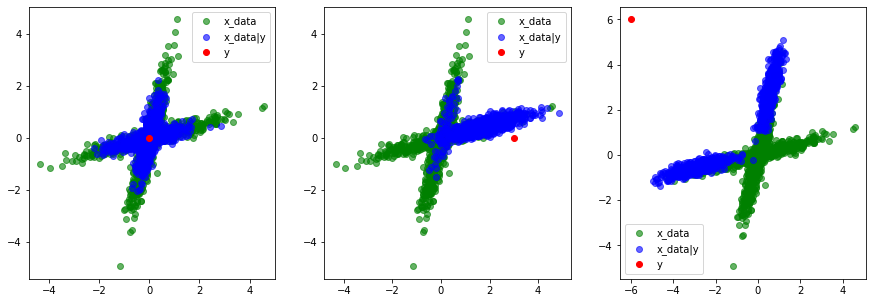

In [5]:
name = 'cross' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)

sample_prior = sample_gaussian(mu_list, sigma_list, pi_list, N)

Y = [np.array([0,0]), np.array([3,0]), np.array([-6,6])] #observation
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    sample_post = sample_posterior(A, Y[i], sigma, N, mu_list, sigma_list, pi_list)

    ax[i].scatter(sample_prior[:, 0], sample_prior[:, 1], alpha=0.6, c='g')
    ax[i].scatter(sample_post[:,0], sample_post[:,1], alpha=0.6, c='b')
    ax[i].grid(False)
    ax[i].plot(Y[i][0],Y[i][1], 'ro')
    ax[i].legend(['x_data', 'x_data|y', 'y'])

## The $\sigma$ impact on the posterior distribution

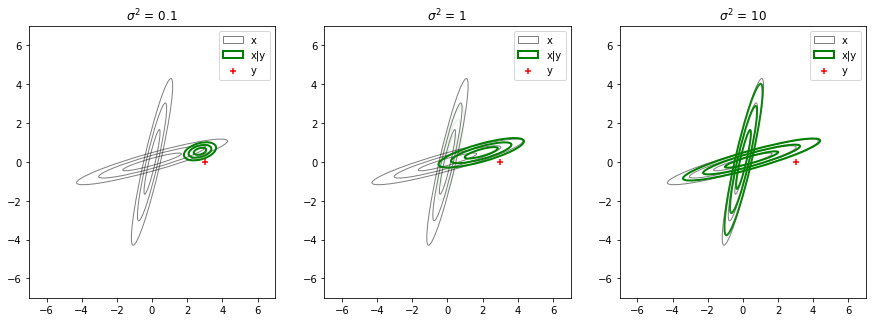

In [6]:
name = 'cross' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
y = np.array([3,0])
Sigma = [0.1, 1, 10]
rbox = 4
for i in range(3):
    ax2 = ax[i]
    sigma = Sigma[i]
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)

    alpha_list = Alpha(pi_list)
    alpha_list_2 = Alpha(p_list)
    
    draw_gaussian_mixture(ax2, mu_list, sigma_list, 0.5*alpha_list, rbox = rbox, color = 'k',  label = 'x')
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list_2, rbox = rbox, color = 'g',  label = 'x|y', linewidth = 2)
    ax2.scatter(y[0], y[1], c = 'r', marker= '+', label = 'y')

    ax2.set_title('$\sigma^2$ = {}'.format(sigma))
    ax2.legend()
    ax2.set_xlim(-7, 7)
    ax2.set_ylim(-7, 7)

# plt.suptitle("Prior and posterior distribution for A = Id and sigma = {}".format(sigma))
plt.show()

# PnP-ULA
First we implement the algorithm then we test it.

In [7]:
def PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha):
    """
    Run PnP-ULA with N iterations, x_0 as initialization, y as an observation, A and sigma constant of the inverse problem,
    delta as a step size and MMSE_denoiser as a denoiser of level epsilon. alpha is the regularization parameter.
    """
    n = y.shape[0] #dimension of the observation, here n = 2
    X = [x_0] #list of the sample
    
    def score_data_fidelity(y,x,A,sigma):
        return A.T@(y-A@x)/sigma**2
    
    for i in tqdm(range(N-1)):
        x_k = X[-1]
        z_k1 = np.random.randn(n)
        x_k1 = x_k + delta * score_data_fidelity(y,x_k,A,sigma) + alpha*delta*(1/epsilon)*(MMSE_denoiser(x_k)-x_k) + np.sqrt(2*delta)*z_k1
        X.append(x_k1)
    X = np.array(X)
    return X

In [8]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
epsilon = 1
MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
delta = 0.5
alpha = 1.5
N = 10000
Y = [np.array([0,0]), np.array([3,0]), np.array([-6,6])] #observation
np.random.seed(42) #for reproductivity

In [9]:
Sample_ULA = []
for i in range(3):
    Sample_ULA.append(PnP_ULA(N, Y[i], Y[i], delta, A, sigma, MMSE_denoiser, epsilon, alpha))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:03<00:00, 2700.16it/s]


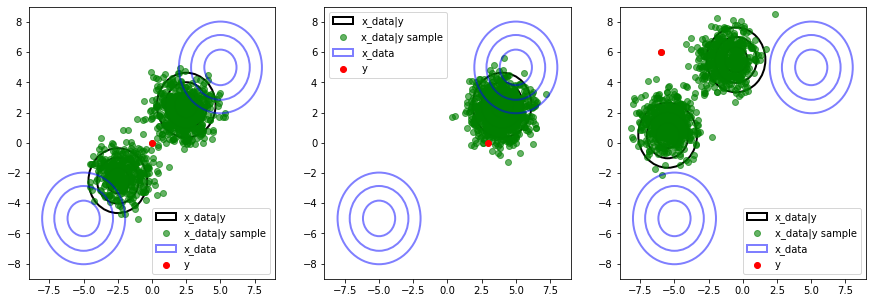

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax2 = ax[i]
    sample_ULA = Sample_ULA[i]
    sample_ULA = np.random.permutation(sample_ULA)[:1000] #take a sample of 1000 points
    y = Y[i]
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 5, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(sample_ULA[:, 0], sample_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    draw_gaussian_mixture(ax2, mu_list, sigma_list, pi_list, rbox = 9, color = 'b',  label = 'x_data', linewidth = 2)
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()

## Influence of $N$ - convergence time

In [67]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
epsilon = 1
MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
delta = 0.5
alpha = 1.5
N = 100000
y = np.array([0,0])
x_0 = y
np.random.seed(42) #for reproductivity

In [68]:
sample_ULA = PnP_ULA(N, y, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha)

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:10<00:00, 9553.93it/s]


In [69]:
N_list = [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,3000,4000,5000,10000,15000,20000,30000,50000,80000,100000]
Wass_dist = []
sample_post = sample_posterior(A, y, sigma, 100000, mu_list, sigma_list, pi_list) #take a sample of the posterior
for n in tqdm(N_list):
    s_ULA = sample_ULA[:n]
    Wass_dist.append(Wasserstein_distance(sample_post, s_ULA))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.33it/s]


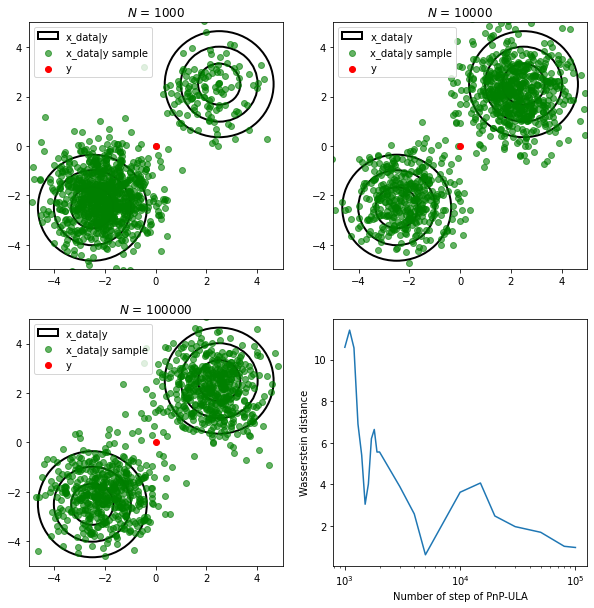

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
n_list = [1000,10000,100000]
ind = [(0,0),(0,1),(1,0)]
for i in range(3):
    ax2 = ax[ind[i]]
    n = n_list[i]
    s_ULA = np.random.permutation(sample_ULA[:n])[:1000] #take a sample of 1000 points
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 5, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(s_ULA[:, 0], s_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()
    ax2.set_title('$N$ = {}'.format(n))

ax2 = ax[1,1]
ax2.set_xlabel('Number of step of PnP-ULA')
ax2.set_ylabel('Wasserstein distance')
ax2.semilogx(N_list,Wass_dist)

## Influence of $\alpha$ - temperature

In [25]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
epsilon = 1
MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
delta = 0.5
N = 10000
y = np.array([0,0])
x_0 = y
np.random.seed(42) #for reproductivity

In [26]:
Alpha_list = [i*0.2 for i in range(21)]
Sample_ULA = []
for alpha in Alpha_list:
    Sample_ULA.append(PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha))

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 8856.32it/s]


In [27]:
Wass_dist = []
sample_post = sample_posterior(A, y, sigma, 100000, mu_list, sigma_list, pi_list) #take a sample of the posterior
for i in tqdm(range(len(Alpha_list))):
    s_ULA = Sample_ULA[i]
    Wass_dist.append(Wasserstein_distance(sample_post, s_ULA))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.94it/s]


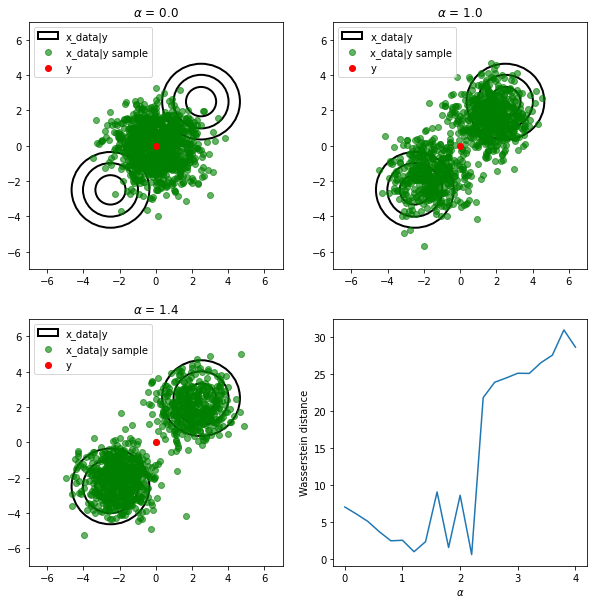

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ind = [0,5,7]
ind2 = [(0,0),(0,1),(1,0)]
for i in range(3):
    ax2 = ax[ind2[i]]
    alpha = Alpha_list[ind[i]]
    sample_ULA = Sample_ULA[ind[i]]
    s_ULA = np.random.permutation(sample_ULA)[:1000] #take a sample of 1000 points
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 7, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(s_ULA[:, 0], s_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()
    ax2.set_title(r'$\alpha$ = {:.1f}'.format(alpha))

ax2 = ax[1,1]
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel('Wasserstein distance')
ax2.plot(Alpha_list,Wass_dist)

## Influence of $\epsilon$ - denoiser parameter

In [30]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
delta = 0.5
alpha = 1.5
N = 10000
y = np.array([0,0])
x_0 = y
np.random.seed(42) #for reproductivity

In [31]:
Epsilon_list = [0.5,1,3,5,7,10,20,30,40,50,80,100]
Sample_ULA = []
for epsilon in Epsilon_list:
    MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
    Sample_ULA.append(PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha))

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 9472.18it/s]


In [32]:
Wass_dist = []
sample_post = sample_posterior(A, y, sigma, 100000, mu_list, sigma_list, pi_list) #take a sample of the posterior
for i in tqdm(range(len(Epsilon_list))):
    s_ULA = Sample_ULA[i]
    Wass_dist.append(Wasserstein_distance(sample_post, s_ULA))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.74it/s]


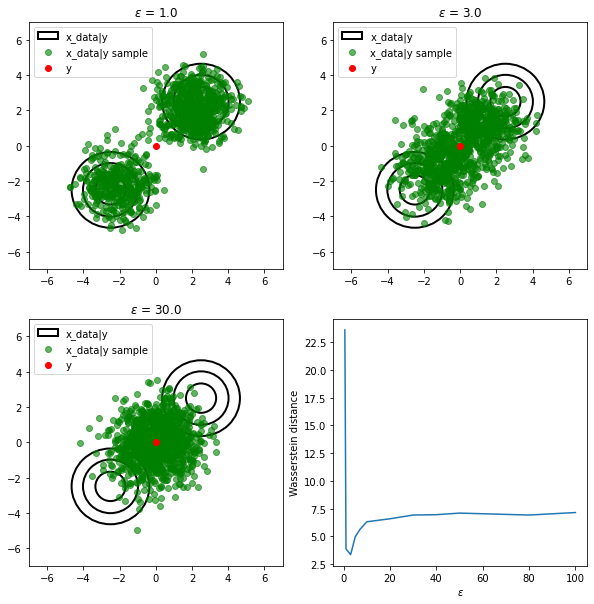

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ind = [1,2,7]
ind2 = [(0,0),(0,1),(1,0)]
for i in range(3):
    ax2 = ax[ind2[i]]
    epsilon = Epsilon_list[ind[i]]
    sample_ULA = Sample_ULA[ind[i]]
    s_ULA = np.random.permutation(sample_ULA)[:1000] #take a sample of 1000 points
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 7, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(s_ULA[:, 0], s_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()
    ax2.set_title(r'$\epsilon$ = {:.1f}'.format(epsilon))

ax2 = ax[1,1]
ax2.set_xlabel(r'$\epsilon$')
ax2.set_ylabel('Wasserstein distance')
ax2.plot(Epsilon_list,Wass_dist)

## Influence of $\delta$ - step size

In [35]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
alpha = 1.5
epsilon = 1.0
N = 10000
y = np.array([0,0])
x_0 = y
np.random.seed(42) #for reproductivity

In [36]:
Delta_list = [0.00001,0.0001,0.001,0.01,0.1, 0.5]
Sample_ULA = []
for delta in Delta_list:
    MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
    Sample_ULA.append(PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha))

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:03<00:00, 2983.30it/s]


In [37]:
Wass_dist = []
sample_post = sample_posterior(A, y, sigma, 100000, mu_list, sigma_list, pi_list) #take a sample of the posterior
for i in tqdm(range(len(Delta_list))):
    s_ULA = Sample_ULA[i]
    Wass_dist.append(Wasserstein_distance(sample_post, s_ULA))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.27it/s]


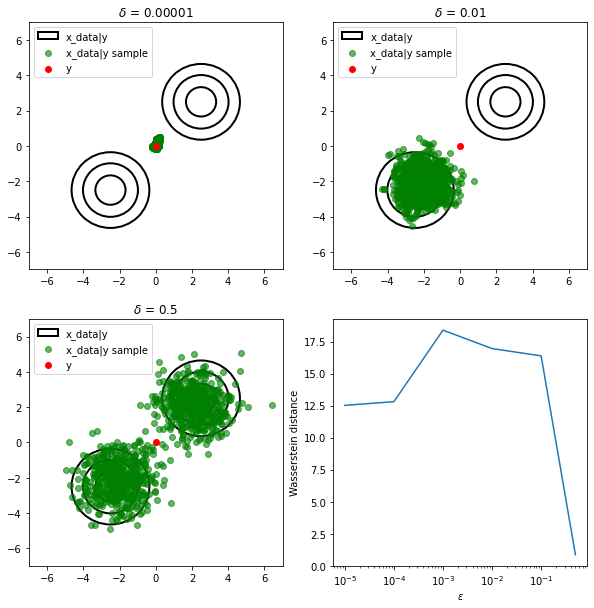

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ind = [0,3,5]
ind2 = [(0,0),(0,1),(1,0)]
title = ['$\delta$ = 0.00001', '$\delta$ = 0.01', '$\delta$ = 0.5']
for i in range(3):
    ax2 = ax[ind2[i]]
    delta = Delta_list[ind[i]]
    sample_ULA = Sample_ULA[ind[i]]
    s_ULA = np.random.permutation(sample_ULA)[:1000] #take a sample of 1000 points
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 7, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(s_ULA[:, 0], s_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()
    ax2.set_title(title[i])

ax2 = ax[1,1]
ax2.set_xlabel(r'$\epsilon$')
ax2.set_ylabel('Wasserstein distance')
ax2.semilogx(Delta_list,Wass_dist)

# Denoiser Mismatch

In [4]:
#first test - constant definition
name = 'cross' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
alpha = 0.3
epsilon = 0.05
delta = 0.05
N = 100000
y = np.array([0,8])
x_0 = np.array([0,0])
np.random.seed(42) #for reproductivity

In [5]:
def Denoiser_cut(epsilon, mu_list, sigma_list, pi_list, cut = -2):
    """
    A function to create a denoiser which have the same behaviour than the perfect denoiser 
    on half of the space and map to zero on the other half of the 2D space.
    """
    denoiser_th = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
    def denoiser_cut(x):
        if x[0]>cut:
            return denoiser_th(x)
        else:
            return np.zeros(2)
    return denoiser_cut

In [6]:
def denoiser_map(plt2, denoiser, prior_data, xmin = -7, xmax = 7, ymin = -7, ymax = 7, npts = 100, seed = 1234, label = False):
    """ 
    function to draw the map of the denoiser denoiser in the domain [xmin,xmax]*[ymin,ymax]. The data of the prior are also draw for lisibility.
    """
    xlen = xmax - xmin
    xmean = (xmax + xmin) / 2
    ylen = ymax - ymin
    ymean = (ymax + ymin) / 2
    np.random.seed(seed)
    X_data = (np.random.random((npts,2))-0.5)*np.array([xlen,ylen])[None,:] - np.array([xmean,ymean])
    
    ppts = int(np.sqrt(npts))
    x = np.linspace(xmin, xmax, ppts)
    y = np.linspace(ymin, ymax, ppts)
    xv, yv = np.meshgrid(x, y)
    X = xv.reshape(-1)
    Y = yv.reshape(-1)
    X_data = np.array([X, Y])
    X_data = X_data.T
    
    X_hat_data = []
    for x in X_data:
        X_hat_data.append(denoiser(x))
    X_hat_data = np.array(X_hat_data)
    bleu_gris = "#6699CC"
    rouge_corail = "#FF6E40"
    bleu_roi = "#3F51B5"
    if label:
        plt2.scatter(prior_data[:, 0], prior_data[:, 1], alpha=0.6, color=bleu_gris, label = 'prior')
    else:
        plt2.scatter(prior_data[:, 0], prior_data[:, 1], alpha=0.6, color=bleu_gris)

    for i in range(len(X_data)):
        x = X_data[i]
        if label and i ==0:
            plt2.plot(x[0],x[1],color = rouge_corail, marker='o', label = 'input')
        else:
            plt2.plot(x[0],x[1],color = rouge_corail, marker='o')

    for i in range(len(X_hat_data)):
        y = X_hat_data[i]
        if label and i ==0:
            plt2.plot(y[0],y[1],color = bleu_roi, marker='o', label = 'output')
        else:
            plt2.plot(y[0],y[1],color = bleu_roi, marker='o')

    for i in range(len(X_data)):
        plt2.plot([X_data[i,0],X_hat_data[i,0]],[X_data[i,1],X_hat_data[i,1]], color = rouge_corail, alpha = 0.3)
    plt2.set_xticks([-8,0,8], ['$-8$','$0$','$8$'], fontsize = 19)
    if label:
        plt2.set_yticks([-8,0,8], ['$-8$','$0$','$8$'], fontsize = 19)
    else:
        plt2.set_yticks([])
    plt2.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


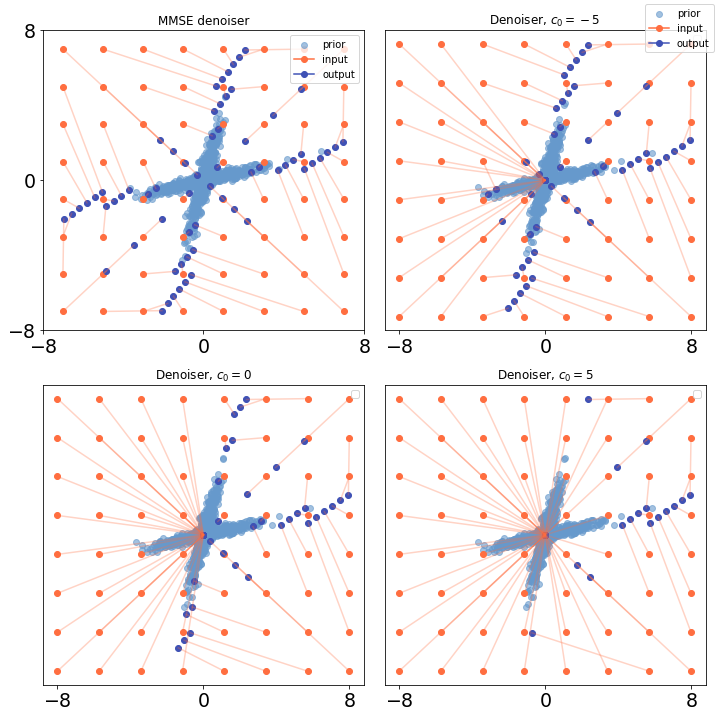

In [7]:
#show some examples of cut denoiser
Cut = [-5,0,5]
fig, ax = plt.subplots(2, 2, figsize = (10,10))

prior_data = sample_gaussian(mu_list, sigma_list, pi_list, 1000)

denoiser_th = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
denoiser_map(ax[0,0], denoiser_th, prior_data, xmin = -7, xmax = 7, ymin = -7, ymax = 7, npts = 68, seed = 1234, label = True) 
ax[0,0].set_title('MMSE denoiser')

indice = [(0,1),(1,0),(1,1)]
for i, cut in enumerate(Cut):
    denoiser_cut = Denoiser_cut(epsilon, mu_list, sigma_list, pi_list, cut = cut)
    denoiser_map(ax[indice[i]], denoiser_cut, prior_data, xmin = -8, xmax = 8, ymin = -8, ymax = 8, npts = 68)
    ax[indice[i]].set_title("Denoiser, $c_0 = {}$".format(cut))
fig.legend()
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


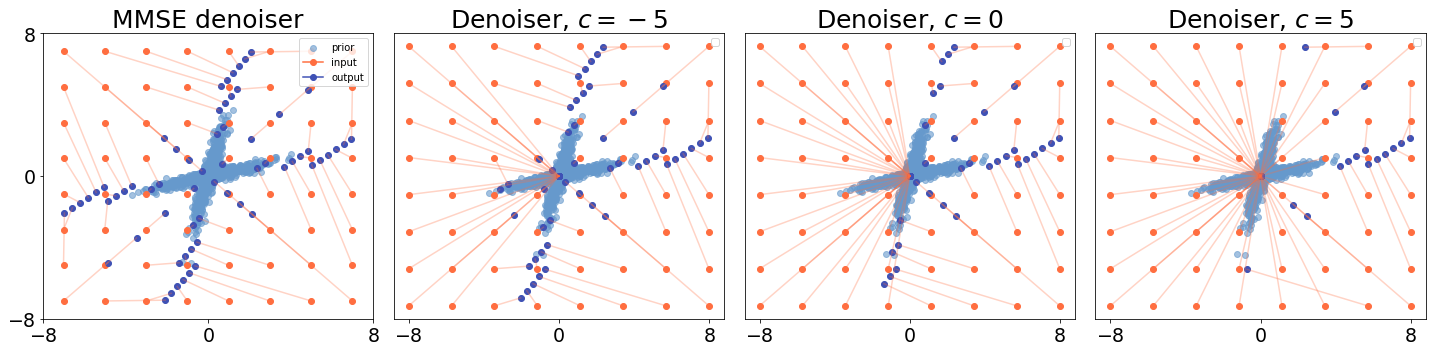

In [8]:
#show some examples of cut denoiser
Cut = [-5,0,5]
fig, ax = plt.subplots(1, 4, figsize = (5*4,5))

prior_data = sample_gaussian(mu_list, sigma_list, pi_list, 1000)

denoiser_th = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
denoiser_map(ax[0], denoiser_th, prior_data, xmin = -7, xmax = 7, ymin = -7, ymax = 7, npts = 68, seed = 1234, label = True) 
ax[0].set_title('MMSE denoiser', fontsize = 25)

indice = [1,2,3]
for i, cut in enumerate(Cut):
    denoiser_cut = Denoiser_cut(epsilon, mu_list, sigma_list, pi_list, cut = cut)
    denoiser_map(ax[indice[i]], denoiser_cut, prior_data, xmin = -8, xmax = 8, ymin = -8, ymax = 8, npts = 68)
    ax[indice[i]].set_title("Denoiser, $c = {}$".format(cut), fontsize = 25)

plt.tight_layout()

In [9]:
#for multiple cut indices
X_list = []
den_list = []

MMSE_den = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
den_list.append(MMSE_den)
X = PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_den, epsilon, alpha)
X_list.append(X)

Cut = np.linspace(-5,5,50)
r = len(Cut)+1

for cut in Cut:
    denoiser_cut = Denoiser_cut(epsilon, mu_list, sigma_list, pi_list, cut = cut)
    den_list.append(denoiser_cut)
    X = PnP_ULA(N, x_0, y, delta, A, sigma, denoiser_cut, epsilon, alpha)
    X_list.append(X)

100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:04<00:00, 21178.54it/s]


In [10]:
#compute the difference with respect with the prior
dist_l2_prior = np.zeros(r)

N1 = len(prior_data)

for i in tqdm(range(1,r)):
    distance1 = 0
    for x in prior_data:
        distance1 += np.sum((den_list[0](x) - den_list[i](x))**2)
    dist_l2_prior[i-1] = np.sqrt(distance1 / N1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.15it/s]


In [11]:
#estimation of the posterior L2 distance between denoisers
dist_l2_posterior = np.zeros(r)

N1 = 1000

for i in tqdm(range(1,r)):
    X = X_list[0]
    X_sample = np.random.permutation(X)[:N1]
    distance1 = 0
    for x in X_sample:
        distance1 += np.sum((den_list[0](x) - den_list[i](x))**2)
    dist_l2_posterior[i-1] = np.sqrt(distance1 / N1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


In [12]:
#computation of the Wasserstein distance between sampling
Dist_wass = []

X_0 = X_list[0]
indices = np.random.randint(0, N, size = 1000)
X_0_s = X_0[indices,:]

for i in tqdm(range(1,r)):
    indices = np.random.randint(0, N, size = 1000)
    X_sample = X_list[i][indices, :]
    M = ot.dist(X_sample, X_0_s)
    dist = ot.emd2(a = [], b = [], M = M)
    Dist_wass.append(dist)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.39it/s]


In [13]:
def correlation(u,v):
    return np.mean((u-np.mean(u))*(v-np.mean(v)))/(np.std(u) * np.std(v))

print('Correlation between Wasserstein distance and posterior L2 distance',correlation(Dist_wass,dist_l2_posterior[:-1]))
print('Correlation between Wasserstein distance and prior L2 distance',correlation(Dist_wass,dist_l2_prior[:-1]))

Correlation between Wasserstein distance and posterior L2 distance 0.9771848295414065
Correlation between Wasserstein distance and prior L2 distance 0.8870461134086026


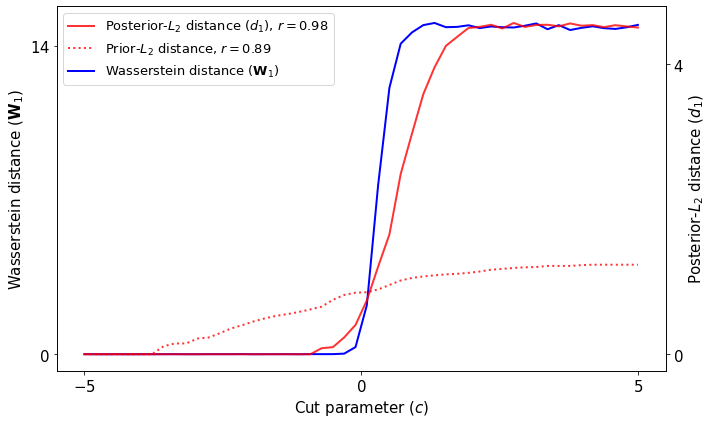

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'b'
ax1.plot(Cut, Dist_wass, color=color, alpha=1, linewidth=2, label = 'Wasserstein distance ($\mathbf{W}_1$)') 
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'r'
corr_dist1 = correlation(Dist_wass, dist_l2_posterior[:-1])
corr_distl2 = correlation(Dist_wass, dist_l2_prior[:-1])

ax2.plot(Cut, dist_l2_posterior[:-1], color=color, label='Posterior-$L_2$ distance ($d_1$), $r = {:.2f}$'.format(corr_dist1), alpha=0.8, linewidth=2)
ax2.plot(Cut, dist_l2_prior[:-1], color=color, label='Prior-$L_2$ distance, $r = {:.2f}$'.format(corr_distl2), alpha=0.8, linewidth=2, linestyle='dotted')

# ax2.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Cut parameter ($c$)', fontsize=15)
ax1.set_xticks([-5,0,5], ['$-5$','$0$','$5$'], fontsize = 15)
ax1.set_yticks([0,14], ['$0$','$14$'], fontsize = 15)
ax2.set_yticks([0,4], ['$0$','$4$'], fontsize = 15)
ax1.set_ylabel('Wasserstein distance ($\mathbf{W}_1$)', color='k', fontsize=15)
ax2.set_ylabel('Posterior-$L_2$ distance ($d_1$)', color='k', fontsize=15)

# Adjusting layout
fig.tight_layout()

# Add legend
lines, labels = ax2.get_legend_handles_labels()
lines += ax1.get_legend_handles_labels()[0]
labels += ax1.get_legend_handles_labels()[1]
plt.legend(lines, labels, loc='upper left', fontsize=13)

plt.show()

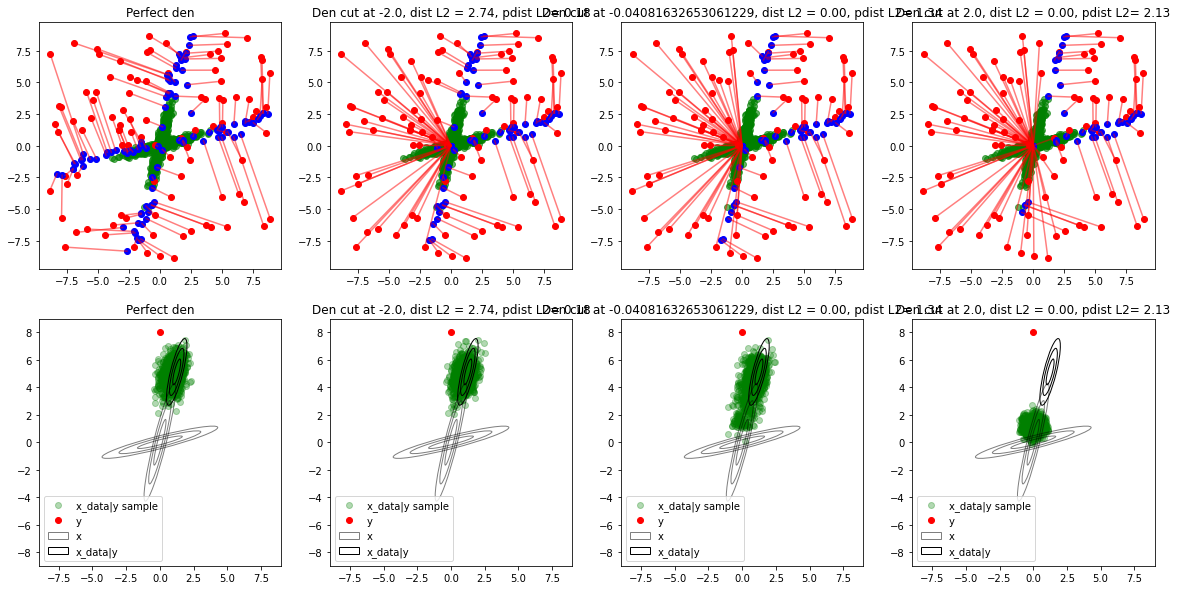

In [119]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

Cut = np.linspace(-2,2,50)
r_box = 9
Title = ['Perfect den']
indices = [0,1,25,50]
for i in range(1,4):
    Title.append('Den cut at {}, dist L2 = {:.2f}, pdist L2= {:.2f}'.format(Cut[indices[i]-1], dist_l2[indices[i]-1], dist_1[indices[i]-1])) 

for i in range(4):
    axi = ax[0,i]
    denoiser_map(axi, den_list[indices[i]], prior_data, xmin = -r_box, xmax = r_box, ymin = -r_box, ymax = r_box)
    axi.set_title(Title[i])

for i in range(4):
    X = X_list[indices[i]]
    axi = ax[1,i]
    X_sample = np.random.permutation(X)[:1000]
    axi.scatter(X_sample[:, 0], X_sample[:, 1], alpha=0.3, c='g', label = 'x_data|y sample')
    axi.plot(y[0],y[1], 'ro', label = 'y')

    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list= Alpha(pi_list)
    alpha1_list= Alpha(p_list)
    draw_gaussian_mixture(axi, mu_list, sigma_list, 0.5*alpha_list, rbox = rbox, color = 'k',  label = 'x')
    draw_gaussian_mixture(axi, mu_list = mu_cond_list, sigma_list = sigma_cond_list, rbox = rbox, color = 'k', alpha_list = alpha1_list, label = 'x_data|y')
    axi.set_title(Title[i])
    axi.set_xlim(-r_box, r_box)
    axi.set_ylim(-r_box, r_box)

plt.show()